In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Set up paths for the Fe sediment flux and Fe vent flux forcing files
forcing_dir = os.path.join(os.sep, "glade", "work", "mlevy", "cesm_inputdata")
fesedflux_file = os.path.join(forcing_dir, "fesedflux_total_reduce_oxic_tx0.66v1.c211019.nc")
feventflux_file = os.path.join(forcing_dir, "feventflux_5gmol_tx0.66v1.c211019.nc")

# Read in both files, rename dimensions to match MOM output
ds1 = xr.open_dataset(fesedflux_file).rename({'DEPTH': 'z_pop_l', 'NLAT': 'yh', 'NLON': 'xh'})
ds2 = xr.open_dataset(feventflux_file).rename({'DEPTH': 'z_pop_l', 'NLAT': 'yh', 'NLON': 'xh'})

# Forcing dataset is the sum of the `FESEDFLUXIN` fields from both files
forcing_da = ds1.FESEDFLUXIN + ds2.FESEDFLUXIN
forcing_da.attrs = ds1.FESEDFLUXIN.attrs
# forcing_da.isel(z_pop_l=0).plot()

In [4]:
# Set up path to history output
rundir = os.path.join(os.sep, "glade", "scratch", "mlevy", "mom.updated_fesedflux", "run")
hist_file = os.path.join(rundir, "mom.updated_fesedflux.mom6.h_bgc_monthly_z_0001_01.nc")

# Read FESEDFLUX field from file
output_da = xr.open_dataset(hist_file, decode_times=False).isel(time=0).FESEDFLUX

# Make sure vertical coordinate matches the coordinate in forcing_da (otherwise differencing won't work)
output_da = output_da.assign_coords(z_pop_l=forcing_da.z_pop_l)

# Unit conversion to match forcing file: 1 nmol/cm^2 = 10 micromol/m^2, 1 -/s = 86400 -/d
if output_da.attrs["units"] == "nmol/cm^2/s":
    output_da.data = output_da.data * 864000
    output_da.attrs["units"] = "micromol/m^2/d"
# output_da.isel(z_pop_l=0).plot()

Min: -4.198941513371463, Max: 7.159429169816502
Min: 0.0, Max: 14.905676512509306
Min: 0.0, Max: 12.347683863740926


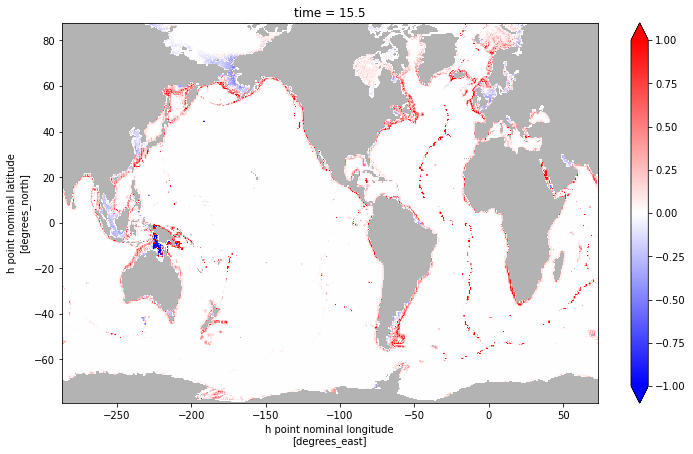

In [5]:
# Print some quick statistics
def print_min_max(da):
    print(f"Min: {da.min().data}, Max: {da.max().data}")

def plot_single_level_diff(diff_da, level=0, **plot_kwargs):
    plot_kwargs['cmap'] = plot_kwargs.get('cmap', 'bwr')
    da = diff_da.isel(z_pop_l=level)
    print_min_max(da)
    fig = plt.figure(figsize=[12,7])
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('0.7')
    da.plot(ax=ax, **plot_kwargs)

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('0.7')

# Difference is model - forcing, so positive values => model > forcing
diff_da = output_da - forcing_da

# Set land mask so we can use dark gray for continents
land_mask = np.logical_or(np.isnan(output_da.isel(z_pop_l=0).data), np.isnan(forcing_da.isel(z_pop_l=0).data))

# Difference is model - forcing, so positive values => model > forcing
diff_da_vert_sum = diff_da.sum('z_pop_l').where(np.logical_not(land_mask))

# Print some stats and then plot
print_min_max(diff_da)
print_min_max(output_da.sum('z_pop_l'))
print_min_max(forcing_da.sum('z_pop_l'))
diff_da_vert_sum.plot(ax=ax, vmin=-1, vmax=1, cmap='bwr');

Min: -0.8984090546070209, Max: 0.017867360488487225


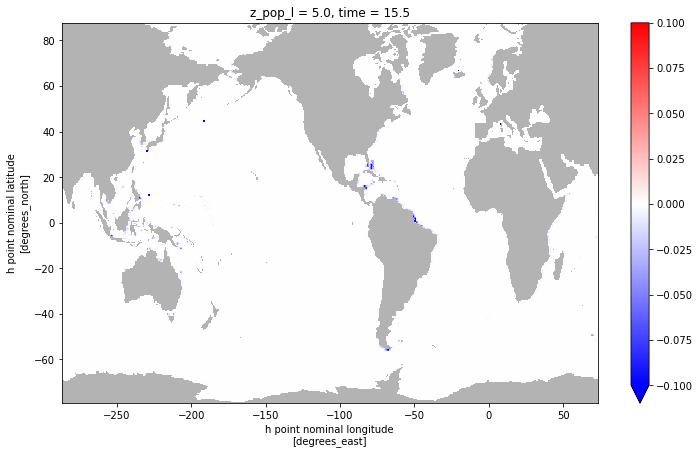

In [6]:
plot_single_level_diff(diff_da, level=0, vmin=-0.1, vmax=0.1)

Min: -4.037644191415682, Max: 6.271110564118584


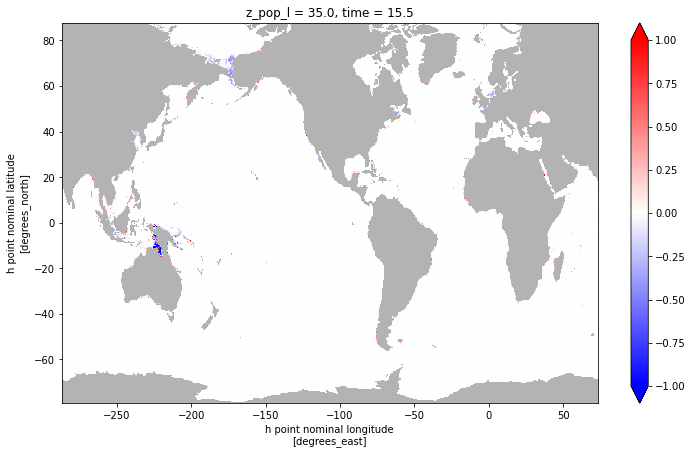

In [7]:
plot_single_level_diff(diff_da, level=3, vmin=-1, vmax=1)